# Autoencoders

In [1]:
# Adaptação para utilizar a sintaxe do TensorFlor 1.x no TensorFlow 2.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import Model, layers

<br/> 
## 1. Redução de Dimensionalidade

In [3]:
base = pd.read_csv('credit_data.csv')
base.head()

,i#clientid,income,age,loan,c#default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [4]:
base.drop(columns='i#clientid', inplace=True)
base.dropna(inplace=True)
base.shape

(1997, 4)

In [5]:
scaler_x = StandardScaler()
base[['income', 'age', 'loan']] = scaler_x.fit_transform(base[['income', 'age', 'loan']])

In [6]:
x = base.drop('c#default', axis=1)
y = base['c#default']

<br/> 
### 1.1 Classificação Sem Redução de Dimensionalidade

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [8]:
colunas = [tf.feature_column.numeric_column(key=col) for col in x.columns]

In [9]:
# Define as funções de treinamento e teste
funcao_train = tf.estimator.inputs.pandas_input_fn(x_train, y_train, batch_size=8, num_epochs=None, shuffle=True)

funcao_test = tf.estimator.inputs.pandas_input_fn(x_test, y_test, batch_size=8, num_epochs=1000, shuffle=False)

In [ ]:
# Cria e treina o classificador
classificador = tf.estimator.DNNClassifier(feature_columns=colunas, hidden_units=(4,4))

classificador.train(input_fn=funcao_train, steps=1000)

In [ ]:
# Realiza o teste
metric_test = classificador.evaluate(input_fn=funcao_test, steps=1000)

In [12]:
metric_test

{'accuracy': 0.98475,
 'accuracy_baseline': 0.8635,
 'auc': 0.99916816,
 'auc_precision_recall': 0.9949482,
 'average_loss': 0.10051989,
 'label/mean': 0.1365,
 'loss': 0.8041591,
 'precision': 0.9859719,
 'prediction/mean': 0.094055794,
 'recall': 0.9010989,
 'global_step': 1000}

<br/> 
### 1.2 Classificação com Redução de Dimensionalidade

#### Criação do Autoencoder

In [13]:
input_neurons = x.shape[1]
hidden_neurons = 2
output_neurons = input_neurons

In [14]:
x_ph = tf.placeholder(tf.float32, shape=(None, input_neurons))

In [15]:
# Cria a estrutura da rede
# utiliza autoencoder linear que não possui função de ativação
hidden_layer = tf.layers.dense(units=hidden_neurons, inputs=x_ph, activation=None)
output_layer = tf.layers.dense(units=output_neurons, inputs=hidden_layer)

erro = tf.losses.mean_squared_error(labels=x_ph, predictions=output_layer)
otimizador = tf.train.AdamOptimizer(learning_rate=0.01)
treinamento = otimizador.minimize(erro)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1000):
        _, loss = sess.run([treinamento, erro], feed_dict={x_ph: x})
        if epoch % 100 == 0:
            print('Epoch {}: erro: {}'.format(epoch+1, loss))
    
    x_encoded = sess.run(hidden_layer, feed_dict={x_ph: x})
    x_decoded = sess.run(output_layer, feed_dict={x_ph: x})

Epoch 1: erro: 2.0109896659851074
Epoch 101: erro: 0.3579404354095459
Epoch 201: erro: 0.3459489345550537
Epoch 301: erro: 0.33832642436027527
Epoch 401: erro: 0.33209994435310364
Epoch 501: erro: 0.3217070996761322
Epoch 601: erro: 0.2892310917377472
Epoch 701: erro: 0.20519137382507324
Epoch 801: erro: 0.18572886288166046
Epoch 901: erro: 0.18566571176052094


In [17]:
x_decoded_unscaled = scaler_x.inverse_transform(x_decoded)
x_decoded_unscaled

array([[6.3550121e+04, 5.8815678e+01, 8.6591641e+03],
       [4.4525793e+04, 4.8898304e+01, 4.4205264e+03],
       [5.8753723e+04, 6.3219036e+01, 7.7162993e+03],
       ...,
       [4.7892660e+04, 2.8293837e+01, 4.7633013e+03],
       [3.6941805e+04, 6.3445316e+01, 3.0678645e+03],
       [6.3608355e+04, 5.5702312e+01, 8.6148633e+03]], dtype=float32)

In [18]:
mae = mean_absolute_error(scaler_x.inverse_transform(x), x_decoded_unscaled, multioutput='raw_values')
mae

array([6.25924366e+03, 4.83594955e-01, 1.32743375e+03])

#### Classificação

In [19]:
x_encoded_df = pd.DataFrame(x_encoded, columns=['att_1', 'att_2'], index=x.index)
x_encoded_df

,att_1,att_2
0,-2.667475,1.535249
1,-0.140482,0.458687
2,-2.231281,1.673053
3,-0.433048,0.376436
4,-1.930204,-0.753729
...,...,...
1995,-0.279089,0.414975
1996,-0.708221,-0.834751
1997,0.063001,-0.676178
1998,0.328499,1.126161


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_encoded_df, y, test_size=0.3, random_state=0)
colunas = [tf.feature_column.numeric_column(key=col) for col in x_encoded_df.columns]

# Define as funções de treinamento e teste
funcao_train = tf.estimator.inputs.pandas_input_fn(x_train, y_train, batch_size=8, num_epochs=None, shuffle=True)
funcao_test = tf.estimator.inputs.pandas_input_fn(x_test, y_test, batch_size=8, num_epochs=1000, shuffle=False)

# Cria e treina o classificador
classificador = tf.estimator.DNNClassifier(feature_columns=colunas, hidden_units=(4,4))
classificador.train(input_fn=funcao_train, steps=1000)

In [ ]:
# Realiza o teste
metric_test = classificador.evaluate(input_fn=funcao_test, steps=1000)

In [22]:
metric_test

{'accuracy': 0.894875,
 'accuracy_baseline': 0.8635,
 'auc': 0.93667716,
 'auc_precision_recall': 0.68756545,
 'average_loss': 0.21867135,
 'label/mean': 0.1365,
 'loss': 1.7493708,
 'precision': 0.7871854,
 'prediction/mean': 0.11850305,
 'recall': 0.31501833,
 'global_step': 1000}

<br/><br/> 
## 2. Stacked Autoencoder

In [23]:
from keras.datasets import mnist

Using TensorFlow backend.


In [24]:
data = mnist.load_data()

x = np.asarray(data[0][0], dtype=np.float32) # 60k dados (28x28)
y = np.asarray(data[0][1], dtype=np.int32)

# Normalização
x = np.array(list(map(lambda value: value / 255., [item for item in x])))

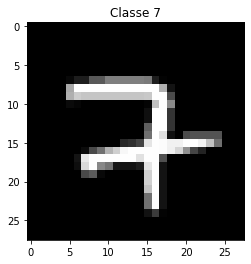

In [25]:
reg = 38
plt.imshow(x[reg], cmap='gray')
plt.title('Classe {}'.format(y[reg]))
plt.show()

In [26]:
x = x.reshape(x.shape[0], -1)
x.shape

(60000, 784)

In [27]:
# Estrutura da rede 
# (784 -> 128 -> 64 -> 128 -> 784)

# Encoder
input_neurons = 28*28
hidden_neurons1 = 128
hidden_neurons2 = 64

# Decoder
hidden_neurons3 = hidden_neurons1
output_neurons = input_neurons

In [28]:
tf.reset_default_graph()

In [29]:
x_ph = tf.placeholder(tf.float32, shape=(None, input_neurons))

In [30]:
# Xavier inicialization, se adapta melhor a sigmoid
# He inicialization (generalização do xavier init), se adapta melhor a relu

inicializador = tf.variance_scaling_initializer()

# Inicialização dos Pesos e Bias
w = {'encoder_hidden1': tf.Variable(inicializador([input_neurons, hidden_neurons1])),
     'encoder_hidden2': tf.Variable(inicializador([hidden_neurons1, hidden_neurons2])),
     'decoder_hidden3': tf.Variable(inicializador([hidden_neurons2, hidden_neurons3])),
     'decoder_output': tf.Variable(inicializador([hidden_neurons3, output_neurons]))}

b = {'encoder_hidden1': tf.Variable(inicializador([hidden_neurons1])),
     'encoder_hidden2': tf.Variable(inicializador([hidden_neurons2])),
     'decoder_hidden3': tf.Variable(inicializador([hidden_neurons3])),
     'decoder_output': tf.Variable(inicializador([output_neurons]))}

In [31]:
# Processo de FeedForward
hidden_layer1 = tf.nn.relu(tf.add(tf.matmul(x_ph, w['encoder_hidden1']), b['encoder_hidden1']))
hidden_layer2 = tf.nn.relu(tf.add(tf.matmul(hidden_layer1, w['encoder_hidden2']), b['encoder_hidden2']))
hidden_layer3 = tf.nn.relu(tf.add(tf.matmul(hidden_layer2, w['decoder_hidden3']), b['decoder_hidden3']))
output_layer = tf.nn.relu(tf.add(tf.matmul(hidden_layer3, w['decoder_output']), b['decoder_output']))

In [32]:
# Calculo do Erro
erro = tf.losses.mean_squared_error(x_ph, output_layer)

# Processo de BackPropagation
otimizador = tf.train.AdamOptimizer(learning_rate=0.001)
treinamento = otimizador.minimize(erro)

In [33]:
BATCH_SIZE = 128
EPOCHS = 50

In [34]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(EPOCHS):
        num_batches = x.shape[0] // BATCH_SIZE
        
        x_inBatches = np.array_split(x, num_batches)
        
        for batch in range(num_batches):
            _, loss = sess.run([treinamento, erro], feed_dict={x_ph: x_inBatches[batch]})
        
        if epoch % 5 == 0 or epoch == EPOCHS-1:
            print('Epoch {}: erro: {}'.format(epoch+1, loss))
        
    w_final, b_final = sess.run([w, b])

Epoch 1: erro: 0.02073177509009838
Epoch 6: erro: 0.013243727385997772
Epoch 11: erro: 0.012387366034090519
Epoch 16: erro: 0.011938277631998062
Epoch 21: erro: 0.011730767786502838
Epoch 26: erro: 0.011653359048068523
Epoch 31: erro: 0.011590308509767056
Epoch 36: erro: 0.01155852060765028
Epoch 41: erro: 0.011552039533853531
Epoch 46: erro: 0.011520680040121078
Epoch 50: erro: 0.011492813006043434


#### Codificação e Decodificação

In [35]:
hid_layer1 = tf.nn.relu(tf.add(tf.matmul(x_ph, w_final['encoder_hidden1']), b_final['encoder_hidden1']))
hid_layer2 = tf.nn.relu(tf.add(tf.matmul(hid_layer1, w_final['encoder_hidden2']), b_final['encoder_hidden2']))
hid_layer3 = tf.nn.relu(tf.add(tf.matmul(hid_layer2, w_final['decoder_hidden3']), b_final['decoder_hidden3']))
out_layer = tf.nn.relu(tf.add(tf.matmul(hid_layer3, w_final['decoder_output']), b_final['decoder_output']))

In [36]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    x_encoded = sess.run(hid_layer2, feed_dict={x_ph: x})
    x_decoded = sess.run(out_layer, feed_dict={x_ph: x})

In [37]:
x_encoded.shape

(60000, 64)

In [38]:
x_decoded.shape

(60000, 784)

#### Visualização Gráfica dos Resultados

In [39]:
def view_result(registros):
    for reg in registros:
        img_orig = x[reg].reshape(28,28)
        img_encoded = x_encoded[reg].reshape(8,8)
        img_decoded = x_decoded[reg].reshape(28,28)

        plt.figure(figsize=(6,2))
        plt.subplot(1,3,1)
        plt.imshow(img_orig)
        plt.title('Classe {}'.format(y[reg]))
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,2)
        plt.imshow(img_encoded)
        plt.title('Img Encoded')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,3)
        plt.imshow(img_decoded)
        plt.title('Img Decoded')
        plt.xticks([])
        plt.yticks([])

        plt.show()

[22567 10080 33427 32834 18027]


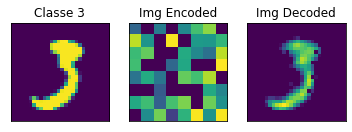

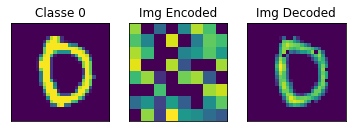

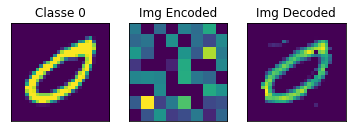

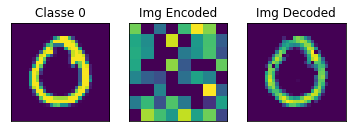

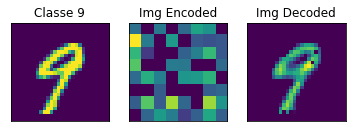

In [40]:
reg = np.random.randint(0, 60000, 5)
print(reg)
view_result(reg)